## Conversion from data to pixel

In [0]:
import numpy as np
from sklearn.metrics import mutual_info_score


def ConvPixel(FVec, xp, yp, A, B, base=1):
    n = len(FVec)
    M = np.ones([int(A), int(B)]) * base
    for j in range(0, n):
        M[int(xp[j]) - 1, int(yp[j]) - 1] = FVec[j]
    zp = np.array([xp, yp])
    dup = {}
    # find duplicate
    for i in range(len(zp[0, :])):
        for j in range(i + 1, len(zp[0])):
            if int(zp[0, i]) == int(zp[0, j]) and int(zp[1, i]) == int(zp[1, j]):
                # if i in dup.keys():
                # print("duplicate:" + str(i) + " " + str(j) + "value: ")
                # dup.add(i)
                # dup[i].add(j)
                dup.setdefault(str(zp[0, i]) + "-" + str(zp[1, i]), {i}).add(j)
                #print("Collisione")

    # print("Collisioni:" + str(len(dup.keys())))
    # print(dup.keys())
    for index in dup.keys():
        x, y = index.split("-")
        M[int(float(x)) - 1, int(float(y)) - 1] = sum(FVec[list(dup[index])]) / len(dup[index])

    return M


In [0]:
import math
import pickle

import pandas as pd
import json as json
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import imageio
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
import cv2
import numpy as np
from sklearn.feature_selection import mutual_info_classif




def dataset_with_best_duplicates(X, y, zp):
    X = X.transpose()
    dup = {}
    for i in range(len(zp[0, :])):
        for j in range(i + 1, len(zp[0])):
            if int(zp[0, i]) == int(zp[0, j]) and int(zp[1, i]) == int(zp[1, j]):
                dup.setdefault(str(zp[0, i]) + "-" + str(zp[1, i]), {i}).add(j)

    # print("Collisioni:" + str(len(dup.keys())))
    # print(dup.keys())
    toDelete = []
    for index in dup.keys():
        mi = []
        x_new = X[:, list(dup[index])]
        mi = mutual_info_classif(x_new, y)
        max = np.argmax(mi)
        dup[index].remove(list(dup[index])[max])
        toDelete.extend(list(dup[index]))
    X = np.delete(X, toDelete, axis=1)
    zp = np.delete(zp, toDelete, axis=1)
    return X.transpose(), zp , toDelete


def Cart2Pixel(Q=None, A=None, B=None, dynamic_size=False,Mutual_Info=False):
    # TODO controls on input
    if A is not None:
        A = A - 1
    if (B != None):
        B = B - 1
    # to dataframe
    feat_cols = ["col-" + str(i + 1) for i in range(Q["data"].shape[1])]
    df = pd.DataFrame(Q["data"], columns=feat_cols)
    if Q["method"] == 'pca':
        pca = PCA(n_components=2)
        Y = pca.fit_transform(df)
    elif Q["method"] == 'tSNE':
        tsne = TSNE(n_components=2, method="exact", )
        Y = tsne.fit_transform(df)
    elif Q["method"] == 'kpca':
        kpca = KernelPCA(n_components=2, kernel='linear')
        Y = kpca.fit_transform(df)

    x = Y[:, 0]
    y = Y[:, 1]
    n, n_sample = Q["data"].shape
    plt.scatter(x, y)
    bbox = minimum_bounding_rectangle(Y)
    plt.fill(bbox[:, 0], bbox[:, 1], alpha=0.2)
    # rotation
    grad = (bbox[1, 1] - bbox[0, 1]) / (bbox[1, 0] - bbox[0, 0])
    theta = np.arctan(grad)
    R = np.asmatrix([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    bboxMatrix = np.matrix(bbox)
    zrect = (R.dot(bboxMatrix.transpose())).transpose()
    # zrect=R.dot(bboxMatrix)
    plt.fill(zrect[:, 0], zrect[:, 1], alpha=0.2)

    coord = np.array([x, y])
    rotatedData = np.array(R.dot(coord))  # Z
    plt.scatter(rotatedData[0, :], rotatedData[1:])
    plt.axis('square')

    # find duplicate
    # for i in range(len(rotatedData[0, :])):
    #     for j in range(i + 1, len(rotatedData[0])):
    #         if rotatedData[0, i] == rotatedData[0, j] and rotatedData[1, i] == rotatedData[1, j]:
    #             print("duplicate:" + str(i) + " " + str(j))
    #

    # nearest point

    min_dist = np.inf
    min_p1 = 0
    min_p2 = 0
    for p1 in range(n):
        for p2 in range(p1 + 1, n):
            d = (rotatedData[0, p1] - rotatedData[0, p2]) ** 2 + (rotatedData[1, p1] - rotatedData[1, p2]) ** 2
            if min_dist > d > 0 and p1 != p2:
                min_p1 = p1
                min_p2 = p2
                min_dist = d
    plt.scatter([rotatedData[0, min_p1], rotatedData[0, min_p2]], [rotatedData[1, min_p1], rotatedData[1, min_p2]])
    plt.show(block=False)

    # euclidean distance
    dmin = np.linalg.norm(rotatedData[:, min_p1] - rotatedData[:, min_p2])
    rec_x_axis = abs(zrect[0, 0] - zrect[1, 0])
    rec_y_axis = abs(zrect[1, 1] - zrect[2, 1])

    if dynamic_size:
        precision_old = math.sqrt(2)
        A = math.ceil(rec_x_axis * precision_old / dmin)
        B = math.ceil(rec_y_axis * precision_old / dmin)
        print("Dynamic [A:" + str(A) + " ; B:" + str(B) + "]")
        if max([A, B]) > Q["max_px_size"]:
            precision = precision_old * Q["max_px_size"] / max([A, B])
            A = math.ceil(rec_x_axis * precision / dmin)
            B = math.ceil(rec_y_axis * precision / dmin)
    # cartesian coordinates to pixels
    xp = np.round(
        1 + (A * (rotatedData[0, :] - min(rotatedData[0, :])) / (max(rotatedData[0, :]) - min(rotatedData[0, :]))))
    yp = np.round(
        1 + (-B) * (rotatedData[1, :] - max(rotatedData[1, :])) / (max(rotatedData[1, :]) - min(rotatedData[1, :])))
    A = max(xp)
    B = max(yp)

    images = []
    print(Q["y"].shape)
    toDelete=0
    if(Mutual_Info==True):
      Q["data"], zp , toDelete = dataset_with_best_duplicates(Q["data"], Q["y"], np.array([xp, yp]))
      images = [ConvPixel(Q["data"][:, i], zp[0], zp[1], A, B)  for i in range(0, n_sample)]

    else:
      images = [ConvPixel(Q["data"][:, i], xp, yp, A, B)  for i in range(0, n_sample)]
      zp=[xp,yp]

        # images.append(ConvPixel(Q["data"][:, i], xp, yp, A, B))
        # filename = "dataset/CICDS2017/images/img" + str(i) + ".jpg"
        # cv2.imwrite(filename, images[i])
        # if i % 10000 == 0:
        #     print(str(i) + "of " + str(n_sample))
    #ret = json.dump([img.tolist() for img in images])

    filename = "/content/drive/My Drive/Tesi/trainingsetImage10x10_Mean.pickle"
    f_myfile = open(filename, 'wb')
    pickle.dump(images, f_myfile)
    f_myfile.close()


    # Save Model to JSON file
    image_model = {"xp": zp[0].tolist(), "yp": zp[1].tolist(), "A": A, "B": B}
    j = json.dumps(image_model)
    f = open("/content/drive/My Drive/Tesi/image_modelD.json", "w")
    f.write(j)
    f.close()



    return images, image_model, toDelete


## Min Rect

In [0]:
import numpy as np
from scipy.spatial import ConvexHull

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    from scipy.ndimage.interpolation import rotate
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
#     rotations = np.vstack([
#         np.cos(angles),
#         -np.sin(angles),
#         np.sin(angles),
#         np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

## Neural Network

In [0]:
import numpy as np
from keras import Model, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Add, \
    Concatenate
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


def deep_train(images, y, param=None):
    print(param)
    x_train, x_test, y_train, y_test = train_test_split(images,
                                                        y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=100)
    x_train = np.array(x_train)
    x_test = np.array(x_test)

    image_size = x_train.shape[1]
    image_size2 = x_train.shape[2]

    x_train = np.reshape(x_train, [-1, image_size, image_size2, 1])
    x_test = np.reshape(x_test, [-1, image_size, image_size2, 1])

    num_filters = param["filter"]
    num_filters2 = param["filter2"]

 

    kernel = param["kernel"]
    
    inputs = Input(shape=(image_size, image_size2, 1))
    print(x_train.shape)
    out = Conv2D(filters=num_filters,
                kernel_size=(kernel, kernel),
                padding="same")(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D(strides=2, pool_size=2)(out)

    out = Conv2D(filters=2 * num_filters,
                kernel_size=(kernel, kernel),
                padding="same")(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D(strides=2, pool_size=2)(out)

    out = Conv2D(filters=4 * num_filters,
                kernel_size=(kernel, kernel),
                padding="same")(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)


    # layer 2
    out2 = Conv2D(filters=num_filters2,
                  kernel_size=(kernel, kernel),
                  padding="same")(inputs)
    out2 = BatchNormalization()(out2)
    out2 = Activation('relu')(out2)
    out2 = MaxPooling2D(strides=2, pool_size=2)(out2)

    out2 = Conv2D(filters=2 * num_filters2,
                  kernel_size=(kernel, kernel),
                  padding="same")(out2)
    out2 = BatchNormalization()(out2)
    out2 = Activation('relu')(out2)
    out2 = MaxPooling2D(strides=2, pool_size=2)(out2)

    out2 = Conv2D(filters=4 * num_filters2,
                  kernel_size=(kernel, kernel),
                  padding="same")(out2)
    out2 = BatchNormalization()(out2)
    out2 = Activation('relu')(out2)
  
  
    # final layer
    outf = Concatenate()([out, out2])
    out_f = AveragePooling2D(strides=2, pool_size=2)(outf)
    out_f = Flatten()(out_f)
    predictions = Dense(2, activation='softmax')(out_f)

    # This creates a model that includes
    # the Input layer and three Dense layers
    model = Model(inputs=inputs, outputs=predictions)

    adam = Adam(lr=param["learning_rate"])

    # Compile the model.
    model.compile(
        optimizer=adam,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    # Train the model.
    hist = model.fit(
        x_train,
        y_train,
        epochs=100,
        verbose=2,
        validation_data=(x_test, y_test),
        batch_size=param["batch"],
        callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=20),  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    )
    model.load_weights('best_model.h5')

    y_test = np.argmax(y_test, axis=1)

    Y_predicted = model.predict(x_test, verbose=0, use_multiprocessing=True, workers=12)

    Y_predicted = np.argmax(Y_predicted, axis=1)

    cf = confusion_matrix(y_test, Y_predicted)


    return model, {"balanced_accuracy_val": balanced_accuracy_score(y_test, Y_predicted) * 100, "TN_val": cf[0][0],
         "FP_val": cf[0][1], "FN_val": cf[1][0], "TP_val": cf[1][1]
         }


## Train

In [0]:
import csv
import json
import pickle
import time

import numpy as np
from hyperopt import STATUS_OK
from hyperopt import tpe, hp, Trials, fmin
from keras import backend as K
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

XGlobal = []
YGlobal = []

XTestGlobal = []
YTestGlobal = []

SavedParameters = []


def hyperopt_fcn(params):
    if(params["filter"]==params["filter2"]):
          return {'loss': np.inf , 'status': STATUS_OK}
    global SavedParameters
    start_time = time.time()
    # for p in SavedParameters:
    #     if p["filter"] == params["filter"] and p["filter2"] == params["filter2"] and p["kernel"] == params["kernel"] and\
    #             p["learning_rate"] == params["learning_rate"] and p["momentum"] == params["momentum"]:
    #         return {'loss': np.inf, 'status': STATUS_OK}
    print("start train")
    model,val = deep_train(XGlobal, YGlobal, params)
    print("start predict")

    Y_predicted = model.predict(XTestGlobal, verbose=0, use_multiprocessing=True, workers=12)
    Y_predicted = np.argmax(Y_predicted, axis=1)
    elapsed_time = time.time() - start_time
    cf = confusion_matrix(YTestGlobal, Y_predicted)
    print(cf)
    print(balanced_accuracy_score(YTestGlobal, Y_predicted))
    K.clear_session()
    # SavedParameters.append(
    #     {"balanced_accuracy": balanced_accuracy_score(YTestGlobal, Y_predicted) * 100, "TN": cf[0][0],
    #      "FP": cf[0][1], "FN": cf[1][0], "TP": cf[1][1], "filter": params["filter"], "filter2": params["filter2"],
    #      "kernel": params["kernel"], "learning_rate": params["learning_rate"], "momentum": params["momentum"]})
    SavedParameters.append(val)
      
    SavedParameters[-1].update(  {"balanced_accuracy_test": balanced_accuracy_score(YTestGlobal, Y_predicted) * 100, "TN_test": cf[0][0],
         "FP_test": cf[0][1], "FN_test": cf[1][0], "TP_test": cf[1][1], "kernel": params["kernel"],
         "learning_rate": params["learning_rate"],
         "batch": params["batch"], 
         "filter1":params["filter"],
         "filter2":params["filter2"],
         "time":time.strftime("%H:%M:%S", time.gmtime(elapsed_time))})
    SavedParameters = sorted(SavedParameters, key=lambda i: i['balanced_accuracy_test'], reverse=True)


    try:
        with open("/content/drive/My Drive/Tesi/Risultati/resNew10x10.csv", 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=SavedParameters[0].keys())
            writer.writeheader()
            writer.writerows(SavedParameters)
    except IOError:
        print("I/O error")

    return {'loss': -balanced_accuracy_score(YTestGlobal, Y_predicted), 'status': STATUS_OK}

def train_norm(param, dataset, norm):
    np.random.seed(param["seed"])
    print("modelling dataset")
    global YGlobal
    YGlobal = to_categorical(dataset["Classification"])
    del dataset["Classification"]
    global YTestGlobal
    YTestGlobal = to_categorical(dataset["Ytest"])
    del dataset["Ytest"]

    global XGlobal
    global XTestGlobal

    if not param["LoadFromJson"]:
        # norm
        Out = {}
        if norm:
            print('NORM Min-Max')
            Out["Max"] = float(dataset["Xtrain"].max().max())
            Out["Min"] = float(dataset["Xtrain"].min().min())
            # NORM
            dataset["Xtrain"] = (dataset["Xtrain"] - Out["Min"]) / (Out["Max"] - Out["Min"])
            dataset["Xtrain"] = dataset["Xtrain"].fillna(0)

        # TODO implement norm 2
        print("trasposing")
        print(YGlobal.shape)
        print( np.argmax(YGlobal, axis=1).shape)

        q = {"data": np.array(dataset["Xtrain"].values).transpose(), "method": param["Metod"],
             "max_px_size": param["Max_P_Size"], "y": np.argmax(YGlobal, axis=1)}
        print(q["method"])
        print(q["max_px_size"])

        # generate images
        XGlobal, image_model, toDelete = Cart2Pixel(q, q["max_px_size"], q["max_px_size"], param["Dynamic_Size"],param["Mutual_Info"])
        del q
        print("Train Images done!")
        # generate testingset image
        if(param["Mutual_Info"]==True):
          dataset["Xtest"] = dataset["Xtest"].drop(dataset["Xtest"].columns[toDelete], axis=1)
        dataset["Xtest"] = np.array(dataset["Xtest"]).transpose()
        print("generating Test Images")
        print(dataset["Xtest"].shape)

        XTestGlobal = [ConvPixel(dataset["Xtest"][:, i], np.array(image_model["xp"]), np.array(image_model["yp"]),
                                 image_model["A"], image_model["B"]) for i in range(0, dataset["Xtest"].shape[1])]
        print("Test Images done!")

        del dataset["Xtest"]

        # saving testingset
        filename = "/content/drive/My Drive/Tesi/testingsetImage10x10_Mean.pickle"
        f_myfile = open(filename, 'wb')
        pickle.dump(XTestGlobal, f_myfile)
        f_myfile.close()

    else:
        XGlobal = dataset["Xtrain"]
        XTestGlobal = dataset["Xtest"]
    del dataset["Xtrain"]
    del dataset["Xtest"]

    XTestGlobal = np.array(XTestGlobal)
    image_size = XTestGlobal.shape[1]
    print("shape"+str(XTestGlobal.shape))
    XTestGlobal = np.reshape(XTestGlobal, [-1, image_size, image_size, 1])
    YTestGlobal = np.argmax(YTestGlobal, axis=1)

    # optimizable_variable = {"filter_size": 3, "kernel": 2, "filter_size2": 6,"learning_rate":1e-5,"momentum":0.8}
    optimizable_variable = {"kernel": hp.choice("kernel", np.arange(2, 7 + 1)),
                            "filter": hp.choice("filter",[16,32,64,128]),
                            "filter2":hp.choice("filter2",[16,32,64,128]),
                            "batch": hp.choice("batch", [64, 128, 256, 512]),
                            "learning_rate": hp.uniform("learning_rate", 0.0001, 0.01)}

    trials = Trials()
    global SavedParameters
    SavedParameters150 = []
    fmin(hyperopt_fcn, optimizable_variable, trials=trials, algo=tpe.suggest, max_evals=50)
    #hyperopt_fcn({"kernel":2,"learning_rate":0.00838526346,"batch":128,"filter":64,"filter2":16})
    print("migliori parametri")
    SavedParameters = sorted(SavedParameters, key=lambda i: i['balanced_accuracy_test'], reverse=True)
    print(SavedParameters[0])

    # returning best model with hyperopt parameters
    model = deep_train(XGlobal, YGlobal, SavedParameters[0])
    print("accuracy" + str(model))
    return model


## Load data from drive

In [0]:
param = {"Max_P_Size": 10, "Dynamic_Size": False, 'Metod': 'tSNE', "ValidRatio": 0.1, "seed": 180, "Mode": "neural",
         "LoadFromJson": False,"Mutual_Info":False,"colab"=True}


In [39]:
import pandas as pd
import csv
import numpy as np
import pickle
from google.colab import drive
drive.mount('/content/drive')

#!cp -r "/content/drive/My Drive/Tesi/pickle10N" /content
#!cp -r "/content/drive/My Drive/Tesi/Original dataset" /content

if param["colab"]:
    if not param["LoadFromJson"]:
      with open('/content/Original dataset/TrainOneCls.csv', 'r') as file:
        data = {"Xtrain": pd.DataFrame(list(csv.DictReader(file))).astype(float), "class": 2}
        print(data["Xtrain"].shape)
        data["Classification"] = data["Xtrain"]["Classification"]
        del data["Xtrain"]["Classification"]
      print("train loaded")
    
      with open('/content/Original dataset/Testing.csv', 'r') as file:
        data["Xtest"]=pd.DataFrame(list(csv.DictReader(file))).astype(float)
        data["Ytest"] = data["Xtest"]["Classification"]
        del data["Xtest"]["Classification"]
        del data["Xtest"]['']
      print("test loaded")
      data2=data
  else:
        images={}
        f_myfile = open('/content/pickle10N/trainingsetImageNew10x10.pickle', 'rb')
        images["Xtrain"] = pickle.load(f_myfile)
        f_myfile.close()
    
    
        f_myfile = open('/content/pickle10N/y_trainingset.pickle', 'rb')
        images["Classification"] = pickle.load(f_myfile)
        f_myfile.close()
    
        f_myfile = open('/content/pickle10N/testingsetImageNew10x10.pickle', 'rb')
        images["Xtest"] = pickle.load(f_myfile)
        f_myfile.close()
    
        f_myfile = open('/content/pickle10N/y_testingset.pickle', 'rb')
        images["Ytest"] = pickle.load(f_myfile)
        f_myfile.close()

else:
     if not param["LoadFromJson"]:
          with open('dataset/CICDS2017/TrainOneCls.csv', 'r') as file:
            data = {"Xtrain": pd.DataFrame(list(csv.DictReader(file))).astype(float), "class": 2}
            print(data["Xtrain"].shape)
            data["Classification"] = data["Xtrain"]["Classification"]
            del data["Xtrain"]["Classification"]
          print("train loaded")
        
          with open('dataset/CICDS2017/Testing.csv', 'r') as file:
            data["Xtest"]=pd.DataFrame(list(csv.DictReader(file))).astype(float)
            data["Ytest"] = data["Xtest"]["Classification"]
            del data["Xtest"]["Classification"]
            del data["Xtest"]['']
          print("test loaded")
          data2=data
     else:
            images = {}
            f_myfile = open('dataset/CICDS2017/param/trainingsetImageNew10x10.pickle', 'rb')
            images["Xtrain"] = pickle.load(f_myfile)
            f_myfile.close()
        
            f_myfile = open('dataset/CICDS2017/param/y_trainingset.pickle', 'rb')
            images["Classification"] = pickle.load(f_myfile)
            images["Classification"]=images["Classification"]
            f_myfile.close()
        
            f_myfile = open('dataset/CICDS2017/param/testingsetImageNew10x10.pickle', 'rb')
            images["Xtest"] = pickle.load(f_myfile)
            f_myfile.close()
        
            f_myfile = open('dataset/CICDS2017/param/y_testingset.pickle', 'rb')
            images["Ytest"] = pickle.load(f_myfile)
            f_myfile.close()     
  



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(100000, 79)
train loaded
test loaded


## Run


modelling dataset
trasposing
(100000, 2)
(100000,)
tSNE
10


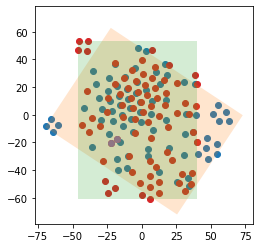

(100000,)
Train Images done!
generating Test Images
(78, 900000)


In [0]:
model = train_norm(param, data, norm=False)

### Reset dataset

In [0]:
f_myfile = open('/content/pickle10N/trainingsetImage10x10_MI.pickle', 'rb')
images["Xtrain2"] = pickle.load(f_myfile)
f_myfile.close()

In [18]:
images["Xtrain2"][0]==images["Xtrain"][0]

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True, False,  True, False,  True,  True, False,  True,
         True],
       [ True,  True,  True, False,  True,  True,  True,  True, False,
         True],
       [ True,  True, False, False, False,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True, False,  True,  True,  True, False,
         True],
       [ True,  True, False,  True,  True,  True,  True,  True, False,
         True]])